In [1]:
import numpy as np
from functions import read_csv,write_csv,interp1D_func,decimate
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor as GP
from sklearn.gaussian_process.kernels import RBF
import subprocess
import os

In [2]:
#Initial guesses
K_range = (0.3E9,0.65E9)
n_range = (3.,6.)
params = {
    'K':K_range[0],
    'n':n_range[0],
}

ks,ns = [x.flatten() for x in  np.meshgrid(*[np.linspace(*r,num = 3) for r in [K_range,n_range]])]


for i,(k,n) in enumerate(zip(ks,ns)):
    results_folder = f'Results/{i}/'
    params = {
        'K':k,
        'n':n,
    }
    write_csv('params.csv',params)
    print(f'Parameters: {params}')
    subprocess.run(['abaqus', 'cae', 'noGui=pillar.py'],shell = True)

Parameters: {'K': 300000000.0, 'n': 3.0}
Parameters: {'K': 475000000.0, 'n': 3.0}
Parameters: {'K': 650000000.0, 'n': 3.0}
Parameters: {'K': 300000000.0, 'n': 4.5}
Parameters: {'K': 475000000.0, 'n': 4.5}
Parameters: {'K': 650000000.0, 'n': 4.5}
Parameters: {'K': 300000000.0, 'n': 6.0}
Parameters: {'K': 475000000.0, 'n': 6.0}
Parameters: {'K': 650000000.0, 'n': 6.0}


In [3]:
test_res = np.loadtxt('original_force.csv')
x_true ,y_true = test_res[:,0],test_res[:,1]
x_samples = decimate(x_true,keep_first = 50,decimate = 10)
y_samples = decimate(y_true,keep_first = 50,decimate = 10)

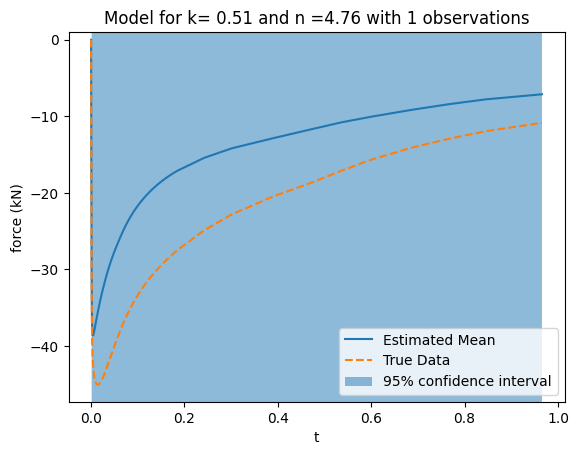

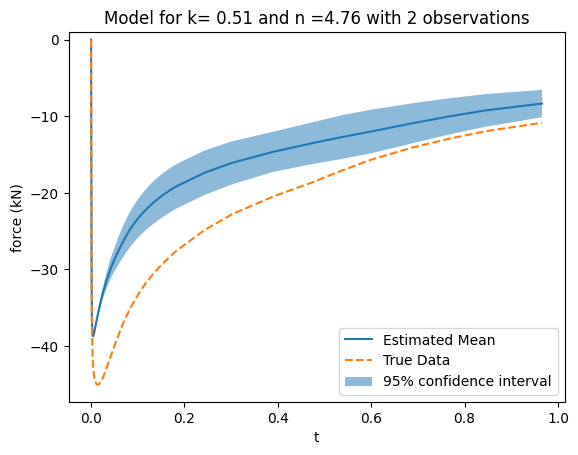

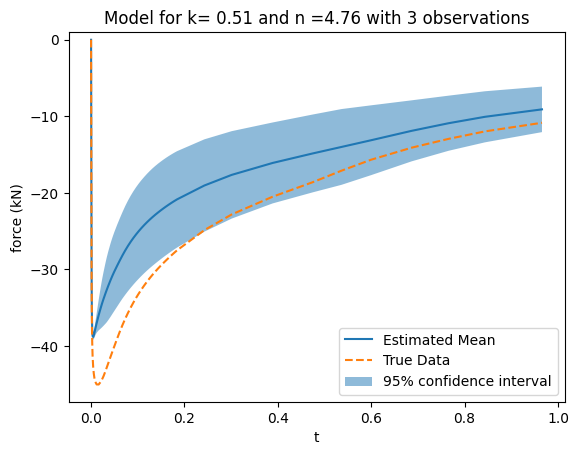

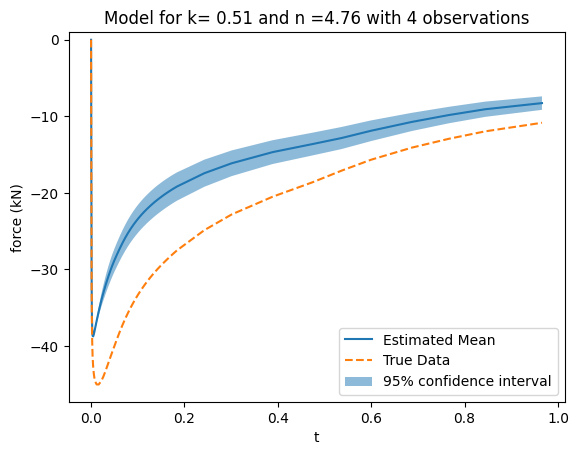

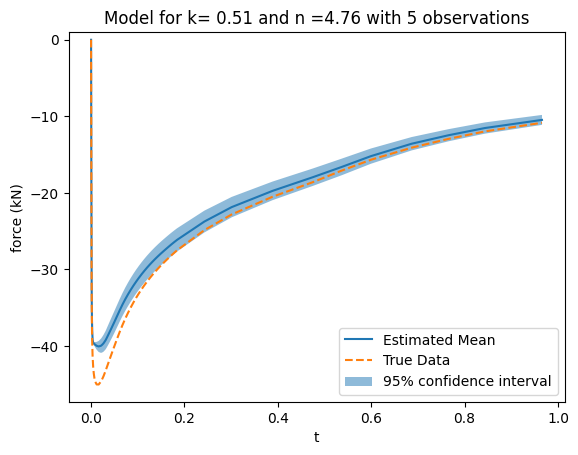

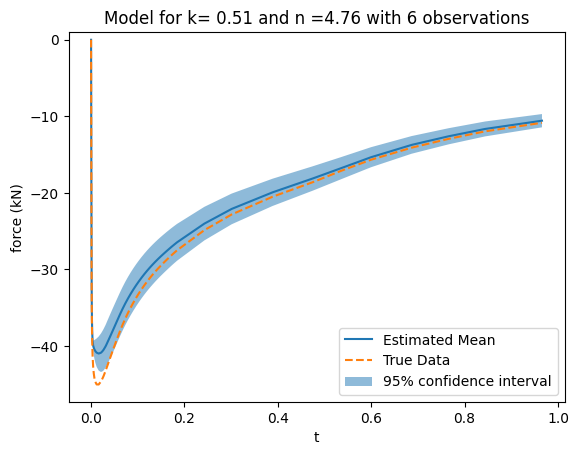

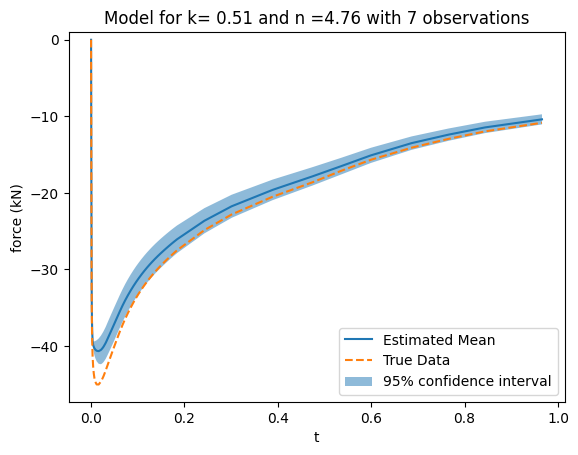

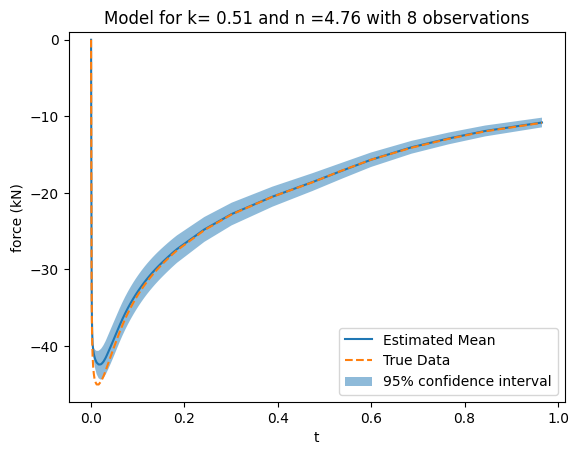

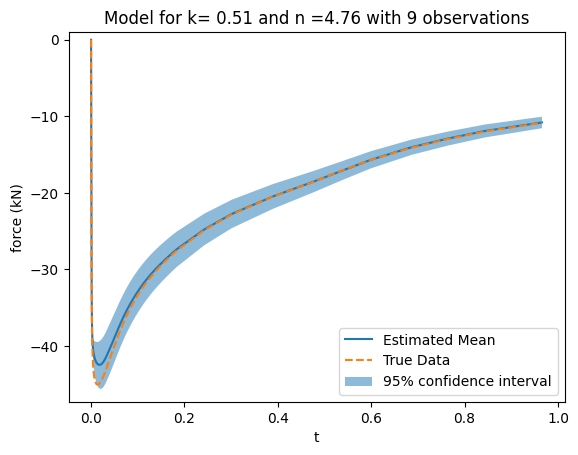

In [5]:
x_train = []
y_train = []
results_folder = 'Results'
if not os.path.exists('images'):
    os.mkdir('images')
for j,folder in enumerate(os.listdir(results_folder),1):
    path = f'{results_folder}/{folder}'
    p = read_csv(f'{path}/params.csv')
    result = np.loadtxt(f'{path}/force.csv',delimiter=',')

    x_i = np.array([p['K']/1e9,p['n']])

    y_interp = interp1D_func(result[:,0],result[:,1]) 
    y_i = y_interp(x_samples)/min(y_true)

    x_train.append(x_i)
    y_train.append(y_i)



    kernel = RBF(1,'fixed')
    gpr = GP(kernel = kernel,normalize_y=True).fit(np.array(x_train),np.array(y_train))

    
    x_test = np.array([[0.51,4.76]])

    y_test,std = gpr.predict(x_test,return_std= True)
    y_test,std = y_test[0],std[0]


    plt.title(f'Model for k= 0.51 and n =4.76 with {j} observations')
    plt.xlabel('t')
    plt.ylabel('force (kN)')
    plt.plot(x_samples,y_test*(min(y_true))/1_000,label = 'Estimated Mean')
    plt.plot(x_samples,y_samples/1_000,label = 'True Data',linestyle = '--')
    z=4
    plt.ylim(top = 1)
    plt.fill_between(
        x_samples[z:].ravel(),
        ((y_test -1.96*std)*(min(y_true)))[z:]/1_000,
        ((y_test +1.96*std)*(min(y_true)))[z:]/1_000,
        alpha=0.5,
        label=r"95% confidence interval",
    )
    plt.legend(loc = 'lower right')
    
    plt.savefig(f'images/iteration{j}.png')
    plt.show()
    
    

In [6]:
from PIL import Image
import os


#Make a Gif of Images
# Directory where your images are stored
image_folder = 'images'
# Output GIF file
output_gif = 'images/surrogate.gif'

# Get all image file paths
images = [img for img in os.listdir(image_folder) if img.endswith((".png", ".jpg", ".jpeg"))]
# Sort the images by filename (optional, based on your naming convention)
images.sort()

# Load images into a list
frames = [Image.open(os.path.join(image_folder, img)) for img in images]

# Save as GIF
# Looping is optional, 0 means infinite loop
frames[0].save(output_gif, save_all=True, append_images=frames[1:], loop=0, duration=500)


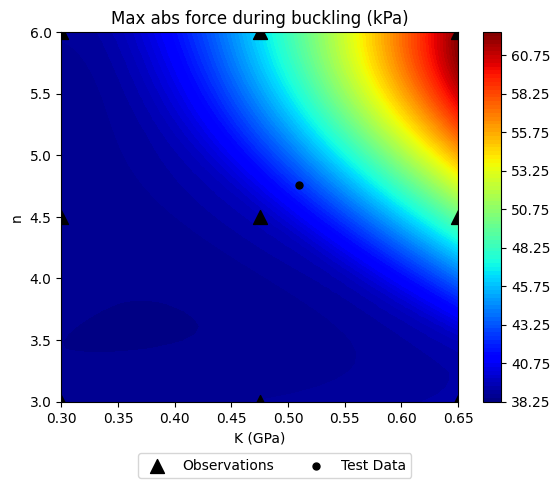

In [7]:
x_pred = np.stack([x.flatten() for x in np.meshgrid(np.linspace(*K_range,50)/1E9,np.linspace(*n_range,50))],axis = -1)

y_pred = gpr.predict(x_pred)
y_pred = np.array([y*(min(y_true)) for y in y_pred])

plt.tricontourf(x_pred[:,0],x_pred[:,1],np.abs(y_pred.min(1)/1000),levels = 100,cmap = 'jet')
plt.colorbar()
plt.xlabel('K (GPa)')
plt.ylabel('n')
plt.title('Max abs force during buckling (kPa)')


observations = np.array(x_train)
plt.scatter(observations[:,0],observations[:,1],s = 100, c='k',marker = '^',label = 'Observations')
plt.scatter(0.510,4.76,s = 100, c='k',marker = '.',label = 'Test Data')
plt.legend(bbox_to_anchor = (0.9,-0.12),ncols = 2)

plt.savefig()
plt.show()